**Loading Libraries**

In [1]:
# Data
library(diversedata)      # Diverse Data Hub data sets

# Core libraries
library(tidyverse)        
library(lubridate)      

# Spatial & mapping
library(sf)               
library(terra)            
library(ggmap)            
library(ggspatial)        
library(maptiles)         
library(leaflet)          
library(leaflet.extras)   

# Visualization & color
library(viridis)          

# Tables & reporting
library(gt)               
library(kableExtra)   

# Modeling & interpretation
library(marginaleffects)  
library(broom) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.13.0, GDAL 3.5.3, PROJ 9.5.1; sf_use_s2() is TRUE

terra 1.8.60


Attaching package: ‘terra’


The following object is masked from ‘package:tidyr’:

    extract


ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles>
ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for det

# 1 Data Cleaning & Processing

-   Converted fire size to numeric
-   Created a binary variable `large_fire` (TRUE if \>200 ha)
-   Filtered out incomplete records

In [2]:
# Reading Data  
wildfire_data <- wildfire

# Clean and prepare base data
wildfire_clean <- wildfire_data |>
  filter(!is.na(assessment_hectares), assessment_hectares > 0) |>
  mutate(
    large_fire = current_size > 200,
    true_cause = as.factor(true_cause),
    detection_agent_type = as.factor(detection_agent_type),
    temperature = as.numeric(temperature),
    wind_speed = as.numeric(wind_speed)
  )

# Drop unused levels for modeling
wildfire_clean <- wildfire_clean |>
  filter(!is.na(true_cause), !is.na(detection_agent_type)) |>
  mutate(
    true_cause = droplevels(true_cause),
    detection_agent_type = droplevels(detection_agent_type)
  )

# 2 Exploratory Data Analysis

**Map of Wildfire Size and Location in Alberta**

This interactive map displays the geographic distribution and relative size of wildfires across Alberta, using red circles sized by fire area. Each point represents a wildfire event, with larger circles indicating more extensive burns. The map reveals regions with concentrated wildfire activity and visually emphasizes differences in fire magnitude across the province.

> **Note**  
> To provide geographic context for our wildfire data, we added a static image of the shapefile representing Alberta's boundaries.  
> This shapefile was sourced from the [Alberta Government Open Data Portal](https://open.alberta.ca/opendata) and specifically corresponds to the *Electoral Division Shapefile (Bill 33, 2017)*.  
> The data was processed and transformed to the appropriate geographic coordinate system to enable mapping alongside our wildfire data set.

![](img/wildfire.png)

**Proportion of Large Fires by Cause**

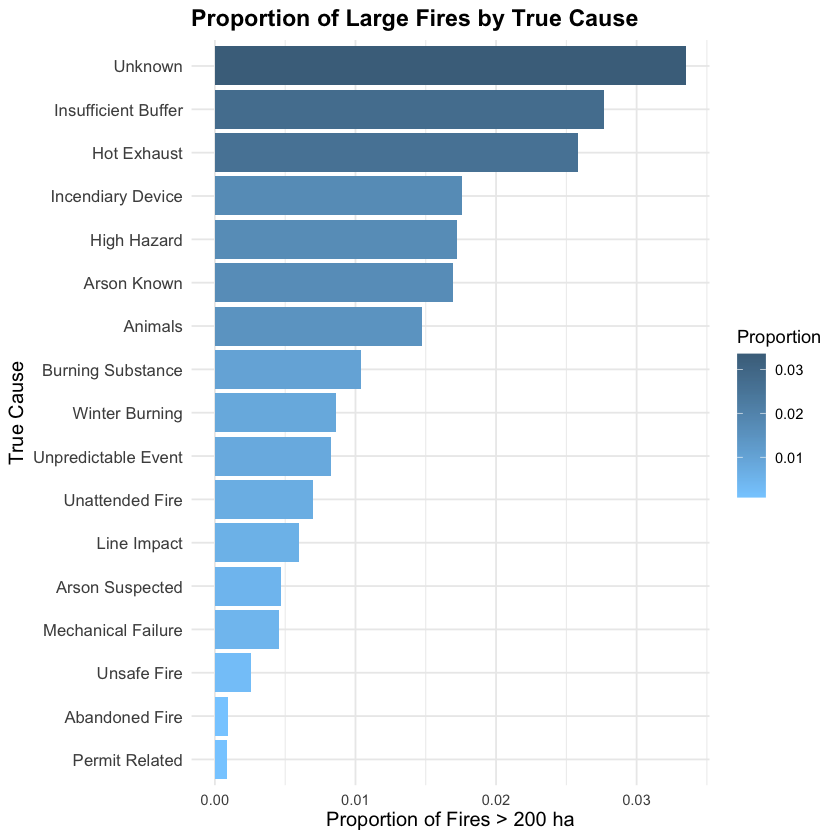

In [3]:
wildfire_clean |>
  group_by(true_cause) |>
  summarize(prop_large = mean(large_fire, na.rm = TRUE)) |>
  filter(prop_large > 0) |>
  ggplot(aes(x = reorder(true_cause, prop_large), y = prop_large, fill = prop_large)) +
  geom_col() +
  coord_flip() +
  scale_fill_gradient(low = "skyblue1", high = "skyblue4") +  
  labs(
    title = "Proportion of Large Fires by True Cause",
    x = "True Cause",
    y = "Proportion of Fires > 200 ha",
    fill = "Proportion"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12)
  )

# 3 Logistic Regression Model

Governments and emergency planners often care about whether a fire becomes large, not necessarily exactly how large. This makes a binary classification more interpretable and actionable for planning responses. Logistic regression predicts probability of exceeding a threshold, such as "Will this fire exceed 200 hectares?" Modeling the probability of exceeding such a threshold is often more operationally useful than modeling exact hectares.

In [Decision Making for Wildfires: A Guide for Applying a Risk Management Process at the Incident Level](https://wfmrda.nwcg.gov/sites/default/files/docs/WFMRDA/Publications/Decision_Making_Wildfires_rmrs_gtr298.pdf?utm_source=chatgpt.com), the authors outline a risk-based decision-making framework. A key concept is identifying risk thresholds to guide decisions. This aligns with the broader goals of wildfire risk management, which emphasize anticipating fire severity and planning appropriate responses. Logistic regression is well-suited to this context because it models the probability of crossing such thresholds, such as a fire becoming large, enabling a clear, interpretable basis for making timely, risk-informed decisions.

We built a logistic regression model to predict the likelihood of a fire becoming large based on a set of environmental and operational factors that are consistently measurable, statistically significant, and operationally relevant.

In our logistic regression model, we selected key environmental and contextual variables from the `wildfire_clean` data set that are well-established drivers of wildfire behavior. These include:

-   `temperature`: Higher temperatures increase evaporation, dry out vegetation, and promote ignition and fire spread.

-   `wind_speed`: Strong winds feed oxygen to the fire and can carry embers over long distances, accelerating spread.

-   `relative_humidity`: Low humidity conditions dry fuels, increasing the probability and intensity of fire ignition.

-   `fire_spread_rate`: Reflects how quickly a fire expands; a dynamic indicator of fire behavior.

-   `fire_type`: Indicates how the fire behaves (e.g., surface vs. crown fire), which affects controllability and risk.

-   `fuel_type`: Different vegetation types burn at different intensities and rates; fuels like grass or timber respond differently under the same conditions.

-   `ia_access`: Stands for Initial Attack Access. Limited access can delay suppression efforts, allowing fires to grow larger.

These variables were chosen because they each represent core determinants of ignition likelihood, fire intensity, and suppression difficulty. As explained in ***Introduction to Wildland Fire*** by **Pyne, Andrews, and Laven**, this theoretical foundation supports our inclusion of both meteorological and environmental variables in the model.

**Mathematical Definition of the Logistic Regression Model**

We aim to estimate the probability that a wildfire becomes large (i.e., burns more than 200 hectares), using logistic regression.

Let:

$$
Y_i = 
\begin{cases}
1, & \text{if fire } i \text{ is large (area > 200 ha)} \\
0, & \text{otherwise}
\end{cases}
$$

$$
\mathbf{x}_i = 
\left( 
\text{temperature}_i, 
\text{wind\_speed}_i, 
\text{relative\_humidity}_i, 
\text{fire\_spread\_rate}_i, 
\text{fire\_type}_i, 
\text{fuel\_type}_i, 
\text{ia\_access}_i 
\right)
$$

Then the model is defined as:

$$
\Pr(Y_i = 1 \mid \mathbf{x}_i) = \frac{1}{1 + \exp(-\eta_i)}
$$

where the linear predictor is:

$$
\eta_i = \beta_0 
+ \beta_1 \cdot \text{temperature}_i 
+ \beta_2 \cdot \text{wind\_speed}_i 
+ \beta_3 \cdot \text{relative\_humidity}_i 
+ \beta_4 \cdot \text{fire\_spread\_rate}_i 
+ \boldsymbol{\beta}_{\text{cat}}^\top \mathbf{x}_{i,\text{cat}}
$$

Here:

$$
\begin{aligned}
\beta_0 & \text{ is the intercept} \\
\boldsymbol{\beta}_{\text{cat}} & \text{ is the vector of coefficients for the categorical predictors} \\
\mathbf{x}_{i,\text{cat}} & \text{ is the vector of dummy variables representing those categorical predictors}
\end{aligned}
$$


In [4]:
model <- glm(
  large_fire ~ temperature + wind_speed + relative_humidity +
    fire_spread_rate + fire_type + fuel_type + ia_access,
  data = wildfire_clean,
  family = "binomial"
)

tidy_model <- tidy(model) |>
  mutate(
    estimate   = round(estimate, 3),
    std.error  = round(std.error, 3),
    statistic  = round(statistic, 2),
    p.value    = round(p.value, 4)
  )

tidy_model

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.016,0.401,-5.03,0.0000
temperature,0.048,0.010,4.66,0.0000
wind_speed,0.050,0.004,11.03,0.0000
relative_humidity,-0.031,0.004,-7.64,0.0000
fire_spread_rate,0.104,0.010,10.30,0.0000
fire_typeGround,-1.354,0.184,-7.37,0.0000
fire_typeSurface,-1.093,0.129,-8.48,0.0000
fire_typeUnknown,-13.012,3683.753,0.00,0.9972
fuel_typeC2,-0.945,0.175,-5.40,0.0000


Higher wind speed (0.050, *p* \< 0.001), temperature (0.048, *p* \< 0.001), and fire spread rate (0.104, *p* \< 0.001) significantly increase the odds of a large wildfire, while relative humidity (-0.031, *p* \< 0.001) decreases it. Compared to crown fires, ground fires (-1.354, *p* \< 0.001) and surface fires (-1.093, *p* \< 0.001) are much less likely to result in large fires.

This logistic regression model estimates the factors influencing the likelihood of a large wildfire. Higher temperature, wind speed, and fire spread rate significantly increase the odds of a large fire, while higher relative humidity decreases it. Certain fire types (e.g., Ground, Surface) and fuel types (e.g., M1, M2, O1a, O1b) are associated with significantly lower odds compared to their respective reference categories. The model shows that higher wind speed, lower humidity, and faster fire spread significantly increase the risk of large wildfires.

Let’s dig into our model further by examining how different environmental and operational factors interact to influence fire outcomes.


# 4 Interpretation of our Model **using `marginaleffects`**

**The Role of Wind Across Fire Causes**

As you've likely noticed, we did not include `true_cause` as a predictor in our logistic regression model because it contains many categories, some of which have very few observations. This can lead to large standard errors, unstable coefficient estimates, and a higher risk of overfitting.

However, `true_cause` remains an important variable for exploratory analysis. Certain ignition causes may be more sensitive to wind. For example, sparks from power lines can spread quickly in high winds, embers from debris burning can travel farther, and unattended fires can escalate rapidly under windy conditions. We chose wind speed for this analysis because it is a well-documented environmental amplifier of fire behavior particularly when interacting with certain ignition causes.

Given these interactions, it's valuable to visualize and investigate how the effect of wind speed on large wild fire development varies across different causes. Let's explore this further through faceted marginal effect plots.

This plot shows how wind speed affects the probability of a large wildfire, and how that effect varies across different true causes of fire.

-   The x-axis shows the different values of `true_cause` (fire ignition source categories).

-   The y-axis shows the marginal effect of wind speed on the predicted probability (i.e., on the response scale) of a fire becoming large.

The plot helps us compare the sensitivity of different fire causes to wind speed. For example, if one cause shows a higher marginal effect, it means that increasing wind speed has a stronger impact on the likelihood of large fires for that cause.


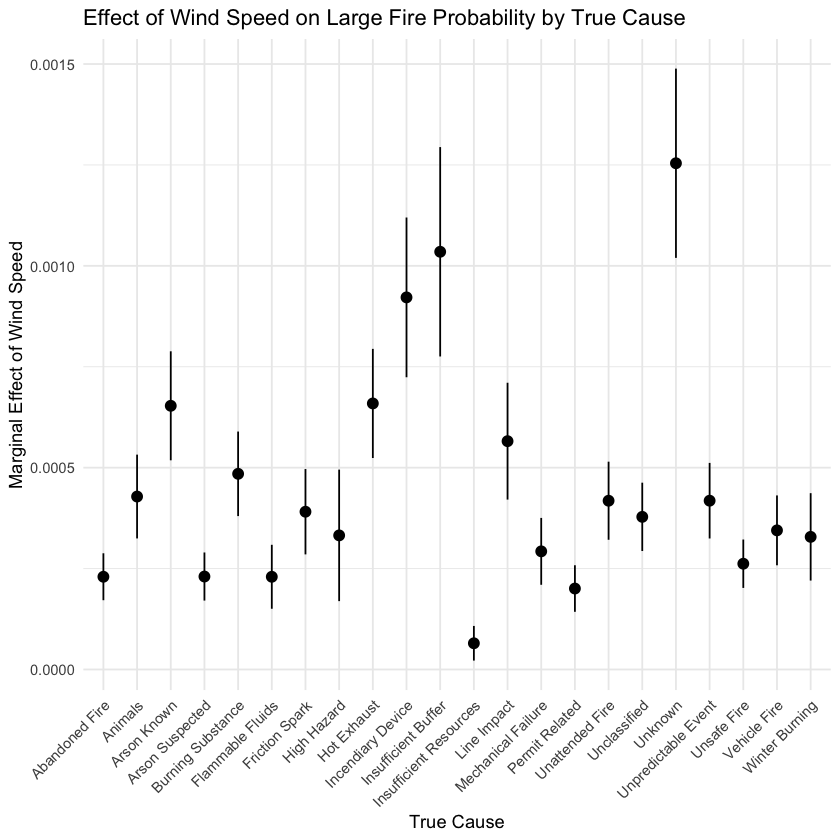

In [5]:
p <- plot_comparisons(
  model,
  variables = "wind_speed",
  by = "true_cause",
  type = "response"
)

p +
  scale_color_manual(values = rep("darkgreen", length(unique(p$data$by)))) +
  scale_fill_manual(values = rep("darkgreen", length(unique(p$data$by)))) +
  labs(
    title = "Effect of Wind Speed on Large Fire Probability by True Cause",
    x = "True Cause",
    y = "Marginal Effect of Wind Speed"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

The marginal effects analysis suggests that wind speed may have a relatively stronger impact on the probability of a fire becoming large when the ignition cause is related to Unknown, Insufficient Buffer, Incendiary Device, Hot Exhaust, or Line Impact. However, the overall changes in predicted probabilities are quite small, and the error bars across causes show substantial overlap. This indicates a high degree of uncertainty and suggests that these differences should be interpreted with caution. While the findings may not yet be strong enough to inform operational decisions, they do highlight areas for further exploration. In particular, when wind is forecasted in regions with a history of certain ignition causes, fire managers could use this exploratory insight to guide risk monitoring strategies, while recognizing that more robust evidence is needed before drawing firm conclusions.

**Interaction Effects via Marginal Effects**

We can also use marginal effects to explore interactions without explicitly adding them to the model, by conditioning on another variable.

This plot shows the marginal effect of `relative_humidity` on the predicted probability of large fire, calculated separately for each level of `fire_type`, based on your fitted model.


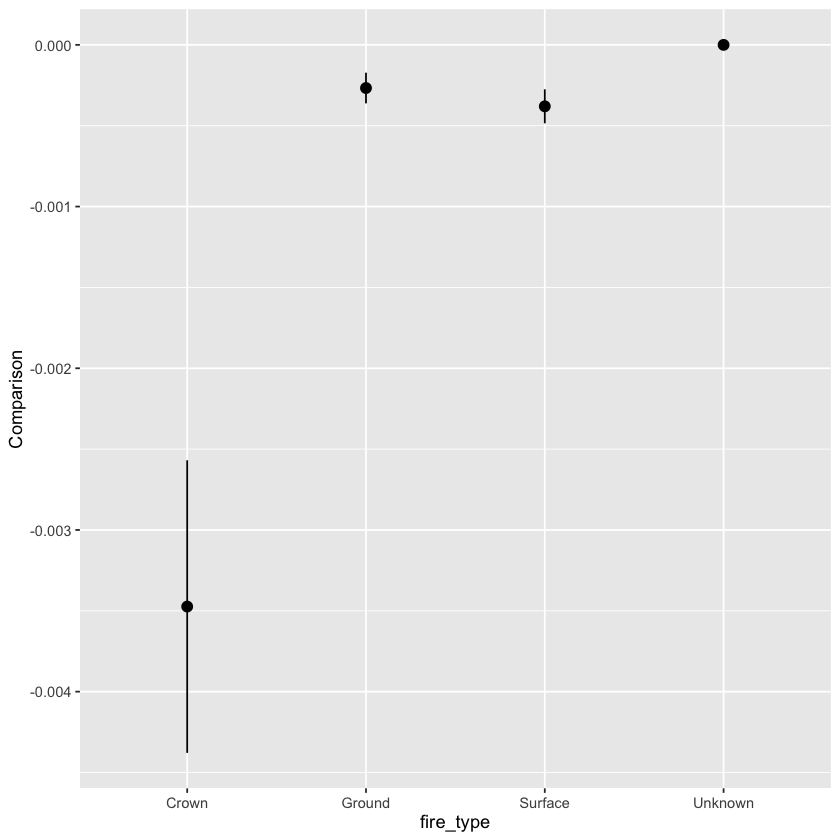

In [6]:
plot_comparisons(model, variables = "relative_humidity", by = "fire_type")

When comparing the marginal effect of relative humidity across fire types, we found that three fire types showed almost no change in large fire probability as humidity increased. However, one fire type exhibited a noticeably stronger negative effect. This suggests that humidity plays a more meaningful role in suppressing fire growth for certain fire types likely those that are more sensitive to moisture availability, such as crown fires—while having minimal effect on others.

# Discussion

This analysis aimed to uncover the key environmental and operational factors associated with the development of large wildfires in Alberta. Using logistic regression and marginal effects, we modeled the probability of a wildfire exceeding 200 hectares, which is a meaningful operational threshold for fire managers.

We found that higher temperature, stronger wind speed, and faster spread rates significantly increase the likelihood of a large wildfire. Conversely, higher relative humidity consistently reduced fire size probability, highlighting its protective role in fire suppression.

In addition to main effects, we explored interaction patterns using marginal effects. While we did not include `true_cause` directly in the model due to its high cardinality and sparse categories, we used it in conjunction with `wind_speed` to explore how ignition causes might modulate wind's influence on fire growth. The marginal effect plots suggest that certain causes—such as incendiary devices, line impacts, or insufficient buffer zones are more sensitive to wind speed, potentially due to the nature of how these fires spread under wind-driven conditions.

Similarly, by plotting the effect of `relative_humidity` across different `fire_type` categories, we observed that humidity suppresses large fire development more strongly in certain fire types, particularly crown fires. This implies that moisture-based mitigation strategies may be more effective in forests prone to crown fire behavior, while having less impact on surface or ground fires.

While some observed differences in marginal effects were small in magnitude and had overlapping confidence intervals, these nuanced insights still provide value. They highlight where future research or localized fire management protocols could focus, especially under climate scenarios with increasing temperature and wind extremes.

Overall, this case study illustrates how statistical modeling paired with domain-informed exploratory tools like marginal effects can support risk-informed, data-driven wildfire management.
